In [1]:
import glob
import numpy as np
import scipy as sp
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import keras
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Reading Data

In [2]:
'''Function generates and returns audio, Mel-frequency cepstral coefficients, Class label and sampling rate'''
class DataGenerator:
    def __init__(self, path):
        self.path = glob.glob(path)
        self.audio = []
        self.mfccs = []
        sr=0
        for path in self.path:
            audio, sr = librosa.load(path)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfcc_mean = np.mean(mfcc, axis=0)
            mfcc_std = np.std(mfcc, axis=0)
            mfcc_normalized = (mfcc - mfcc_mean) / mfcc_std
            self.mfccs.append(mfcc_normalized.T)
            self.audio.append(audio)
        self.mfccs = pad_sequences(self.mfccs, maxlen=45, dtype='float32', padding='post', truncating='post')
        self.sr = sr
    def classify(self):
        self.audiolabel = []
        for path in self.path:
            self.audiolabel.append(int(path[34]))
        return self.audio,np.asarray(self.mfccs), np.asarray(self.audiolabel), self.sr


In [3]:
path = '/kaggle/input/audio-mnist/data/*/*.wav'
describe = ['Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine']
datagenarator = DataGenerator(path)
audio,mfccs,y,sample_rate = datagenarator.classify()

In [4]:
'''Sample of one audio file'''
ipd.Audio(audio[100],rate = sample_rate)

In [5]:
'''Class label of audio'''
describe[y[100]]

'Nine'

In [6]:
sample_rate

22050

In [7]:
mfccs[3].shape

(45, 13)

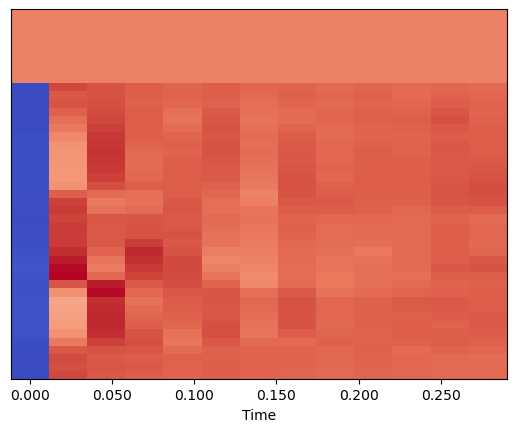

In [8]:
'''mfcc spectrogram'''
librosa.display.specshow(mfccs[0],x_axis='time')

In [9]:
labels = to_categorical(y)

In [10]:
labels[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [11]:
'''Split the dataset into training, testing and validation sets'''
X_train, X_temp, y_train, y_temp = train_test_split(mfccs, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
'''Reshape the input data, Flattening it'''
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

In [13]:
'''Build the neural network model'''
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [14]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
657/657 [==============================] - 6s 4ms/step - loss: 1.8294 - accuracy: 0.3068 - val_loss: 1.5007 - val_accuracy: 0.4042
Epoch 2/100
657/657 [==============================] - 2s 4ms/step - loss: 0.9283 - accuracy: 0.6356 - val_loss: 0.6884 - val_accuracy: 0.7509
Epoch 3/100
657/657 [==============================] - 2s 4ms/step - loss: 0.5722 - accuracy: 0.7926 - val_loss: 0.4702 - val_accuracy: 0.8344
Epoch 4/100
657/657 [==============================] - 3s 4ms/step - loss: 0.4113 - accuracy: 0.8573 - val_loss: 0.4151 - val_accuracy: 0.8531
Epoch 5/100
657/657 [==============================] - 2s 4ms/step - loss: 0.3010 - accuracy: 0.9011 - val_loss: 0.2595 - val_accuracy: 0.9182
Epoch 6/100
657/657 [==============================] - 2s 4ms/step - loss: 0.2317 - accuracy: 0.9269 - val_loss: 0.2007 - val_accuracy: 0.9382
Epoch 7/100
657/657 [==============================] - 2s 4ms/step - loss: 0.1830 - accuracy: 0.9429 - val_loss: 0.1923 - val_accuracy: 0.9362

In [15]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

print(f"Test Accuracy: {accuracy*100:.2f}%")

141/141 [==============================] - 0s 3ms/step - loss: 0.0385 - accuracy: 0.9904
Test Loss: 0.0385
Test Accuracy: 99.04%


In [16]:
'''Simple code for understanding Classification of audio using simple nueral network
    Modify it as per your wish, Let me know if i made any mistakes'''

'Simple code for understanding Classification of audio using simple nueral network\n    Modify it as per your wish, Let me know if i made any mistakes'